In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/drive/MyDrive/Colab Notebooks/train.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

zip_ref = zipfile.ZipFile('/content/drive/MyDrive/Colab Notebooks/valid.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

zip_ref = zipfile.ZipFile('/content/drive/MyDrive/Colab Notebooks/test_new.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
# Import OS module
import os

# Imports
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt

# Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import callbacks, layers, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img,img_to_array
from keras.applications import imagenet_utils
from tensorflow.keras.applications.densenet import DenseNet121, preprocess_input
from tensorflow.keras.models import Sequential
%matplotlib inline

In [ ]:
image_size = 224
target_size = (image_size, image_size)
input_shape = (image_size, image_size, 3)
grid_shape = (1, image_size, image_size, 3)

batch_size = 32

train_dir = "/content/train"
test_dir = "/content/test"
valid_dir = "/content/valid"

In [ ]:
num_classes = len(os.listdir(train_dir))

In [ ]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Data generators
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical'
)

valid_data = test_datagen.flow_from_directory(
    valid_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)
test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)




Found 70295 images belonging to 38 classes.
Found 17572 images belonging to 38 classes.
Found 1812 images belonging to 1 classes.


In [ ]:
densenet = DenseNet121(
    weights="imagenet",
    include_top=False,
    input_shape=input_shape
)

# Allow the base model layers to be trainable
densenet.trainable = True

# Fine-tuning - freeze the first few layers
for layer in densenet.layers[:-10]:
    layer.trainable = False
densenet.summary()

model = Sequential()
model.add(densenet)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(len(train_data.class_indices), activation="softmax"))
model.summary()

Model: "densenet121"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 zero_padding2d_4 (ZeroPadd  (None, 230, 230, 3)          0         ['input_3[0][0]']             
 ing2D)                                                                                           
                                                                                                  
 conv1/conv (Conv2D)         (None, 112, 112, 64)         9408      ['zero_padding2d_4[0][0]']    
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1/conv[0][0]']

In [ ]:
model.compile(
    optimizer=keras.optimizers.Adam(lr=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

In [ ]:
num_epochs = 30
history = model.fit(
    train_data,
    epochs=num_epochs,
    steps_per_epoch=300,
    validation_data=valid_data,
    validation_steps=300,
    callbacks=[early_stopping]
)

Epoch 1/30
300/300 [==============================] - 192s 594ms/step - loss: 1.2306 - accuracy: 0.7178 - val_loss: 0.2142 - val_accuracy: 0.9581
Epoch 2/30
300/300 [==============================] - 176s 586ms/step - loss: 0.3326 - accuracy: 0.9216 - val_loss: 0.1436 - val_accuracy: 0.9624
Epoch 3/30
300/300 [==============================] - 175s 581ms/step - loss: 0.2017 - accuracy: 0.9490 - val_loss: 0.0880 - val_accuracy: 0.9767
Epoch 4/30
300/300 [==============================] - 176s 586ms/step - loss: 0.1670 - accuracy: 0.9542 - val_loss: 0.0610 - val_accuracy: 0.9839
Epoch 5/30
300/300 [==============================] - 161s 537ms/step - loss: 0.1462 - accuracy: 0.9586 - val_loss: 0.0806 - val_accuracy: 0.9771
Epoch 6/30
300/300 [==============================] - 175s 583ms/step - loss: 0.1184 - accuracy: 0.9664 - val_loss: 0.0575 - val_accuracy: 0.9829
Epoch 7/30
300/300 [==============================] - 175s 583ms/step - loss: 0.1157 - accuracy: 0.9638 - val_loss: 0.0584 -

In [ ]:
test_loss, test_accuracy = model.evaluate(test_images)

In [ ]:
class_mapping = train_data.class_indices

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# Get predictions for the test set
y_pred = model.predict(test_data, steps=len(test_data))
y_pred_classes = np.argmax(y_pred, axis=1)

# Get true labels
true_classes = test_data.classes

57/57 [==============================] - 8s 98ms/step


In [ ]:
print(classification_report(true_classes, y_pred_classes, target_names=class_mapping.keys()))

                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       1.00      1.00      1.00        48
                                 Apple___Black_rot       1.00      1.00      1.00        48
                          Apple___Cedar_apple_rust       1.00      1.00      1.00        48
                                   Apple___healthy       1.00      1.00      1.00        48
                               Blueberry___healthy       1.00      1.00      1.00        48
          Cherry_(including_sour)___Powdery_mildew       1.00      1.00      1.00        36
                 Cherry_(including_sour)___healthy       1.00      1.00      1.00        48
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       1.00      0.90      0.95        48
                       Corn_(maize)___Common_rust_       0.96      1.00      0.98        48
               Corn_(maize)___Northern_Leaf_Blight       0.94      1.00      0.

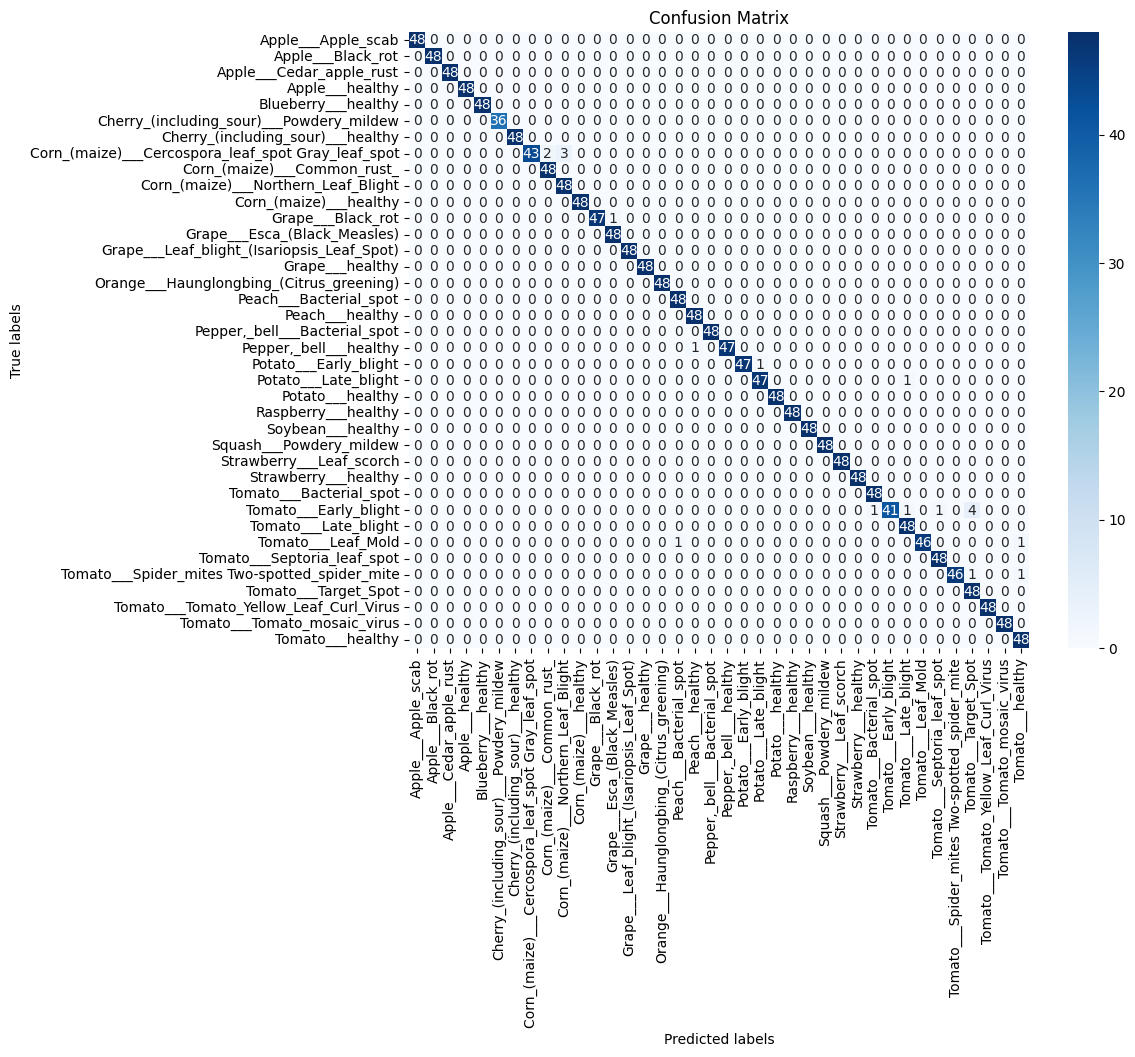

In [ ]:
import seaborn as sns

# Calculate confusion matrix
conf_matrix = confusion_matrix(true_classes, y_pred_classes)

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_mapping.keys(), yticklabels=class_mapping.keys())
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

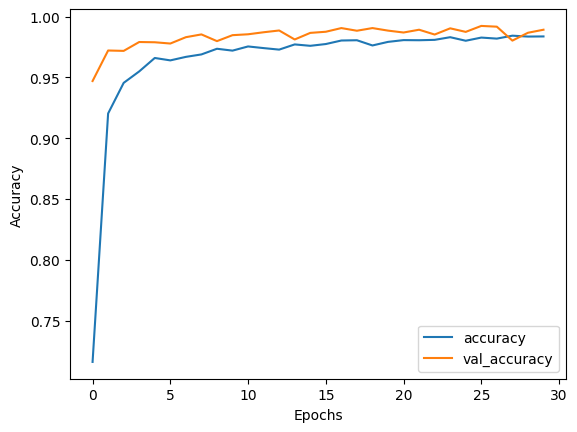

In [ ]:
hist = history.history

# Plot accuracy and validation accuracy
plt.plot(hist["accuracy"], label="accuracy")
plt.plot(hist["val_accuracy"], label="val_accuracy")

# Add the labels and legend
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend()

plt.show()

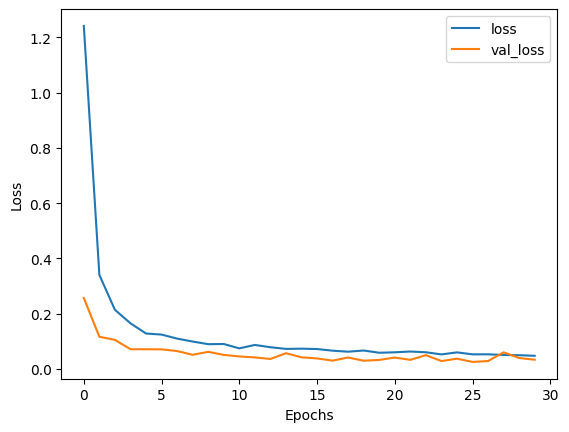

In [ ]:
plt.plot(hist["loss"], label="loss")
plt.plot(hist["val_loss"], label="val_loss")

# Add the labels and legend
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()

plt.show()

In [ ]:
model.save("/content/drive/MyDrive/DenseNet121.h5")

In [ ]:
import json

from IPython.display import FileLink

# Link the files
FileLink("./content/drive/MyDrive/DenseNet121.h5")

/content/content/drive/MyDrive/DenseNet121.h5